In [19]:
import numpy as np

import pandas as pd
import json
from pandas.io.json import json_normalize
import glob
import os

import cv2
from IPython.display import Image
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Step 1: Collect all the json files

* Since each photo has a cooresponding annotations json file, we can use the `glob` library to collect them all into a list.

* Then, we can run a for-loop which converts each json file into a pandas dataframe and concatenate them all into one single dataframe

In [2]:
# Path to json files
folder_path = '../data/raw/train/annotations/'

# List of json files extracted using glob()
json_files = glob.glob(f"{folder_path}/*.json")

In [3]:
# Checking the length of the list to make sure all of the files are present
len(json_files)

60578

In [4]:
# for-loop to create a list of dataframes
annot_df_list = [] 
for file in json_files:
    with open(file) as f:
        data = json.load(f)
    temp = pd.json_normalize(data)
    temp['file_name'] = file.split('/')[-1].split('.')[0] # we will need the file name to match the images with the cooresponding annotations
    annot_df_list.append(temp)

In [5]:
# Concatenate our list of dataframes into a single dataframe
annot_df = pd.concat(annot_df_list, axis=0, ignore_index=True)
annot_df.head()

,source,chart-type,text,data-series,plot-bb.height,plot-bb.width,plot-bb.x0,plot-bb.y0,axes.x-axis.ticks,axes.x-axis.tick-type,axes.x-axis.values-type,axes.y-axis.ticks,axes.y-axis.tick-type,axes.y-axis.values-type,visual-elements.bars,visual-elements.boxplots,visual-elements.dot points,visual-elements.lines,visual-elements.scatter points,file_name
0,generated,scatter,"[{'id': 0, 'polygon': {'x0': 85, 'x1': 478, 'x...","[{'x': 1949.4200576738224, 'y': 66.68303958393...",231,416,57,65,"[{'id': 9, 'tick_pt': {'x': 57, 'y': 295}}, {'...",markers,numerical,"[{'id': 1, 'tick_pt': {'x': 57, 'y': 65}}, {'i...",markers,numerical,[],[],[],[],"[[{'x': 89.33333333333334, 'y': 75.59999999999...",e91e28111e86
1,generated,vertical_bar,"[{'id': 0, 'polygon': {'x0': 109, 'x1': 355, '...","[{'x': 'Jordan', 'y': 88.35159235668789}, {'x'...",164,393,68,37,"[{'id': 11, 'tick_pt': {'x': 87, 'y': 200}}, {...",markers,categorical,"[{'id': 3, 'tick_pt': {'x': 68, 'y': 37}}, {'i...",markers,numerical,"[{'height': 103, 'width': 19, 'x0': 77, 'y0': ...",[],[],[],[],75c0449f6917
2,generated,scatter,"[{'id': 0, 'polygon': {'x0': 113, 'x1': 383, '...","[{'x': 0.9445463278316278, 'y': 52.13870797394...",203,409,54,21,"[{'id': 3, 'tick_pt': {'x': 54, 'y': 223}}, {'...",markers,numerical,"[{'id': 17, 'tick_pt': {'x': 54, 'y': 21}}, {'...",markers,numerical,[],[],[],[],"[[{'x': 68.76190476190474, 'y': 188.2023809523...",66dd2a250237
3,generated,vertical_bar,"[{'id': 0, 'polygon': {'x0': 71, 'x1': 465, 'x...","[{'x': 'Cuba', 'y': 75695.38632268383}, {'x': ...",165,396,89,60,"[{'id': 14, 'tick_pt': {'x': 110, 'y': 225}}, ...",markers,categorical,"[{'id': 3, 'tick_pt': {'x': 89, 'y': 60}}, {'i...",markers,numerical,"[{'height': 124, 'width': 12, 'x0': 104, 'y0':...",[],[],[],[],58595c30beab
4,generated,scatter,"[{'id': 0, 'polygon': {'x0': 75, 'x1': 461, 'x...","[{'x': 0.8933632249058832, 'y': 5.440194292653...",165,394,79,69,"[{'id': 12, 'tick_pt': {'x': 79, 'y': 233}}, {...",markers,numerical,"[{'id': 3, 'tick_pt': {'x': 79, 'y': 69}}, {'i...",markers,numerical,[],[],[],[],"[[{'x': 93.33333333333333, 'y': 210.9666666666...",497a547454d7


# Step 2: Collect all Images

* Similar to our approach for the json files, we will collect all the jpg files using glob.

* We will create a dataframe of the image path and file name.

In [6]:
# Path to image files
folder_path = '../data/raw/train/images/'

# List of json files extracted using glob()
image_files = glob.glob(f"{folder_path}/*.jpg")

In [7]:
# List of file names without the .jpg
# We will need these for merging with the annotations data
file_names = [x.split('/')[-1].split('.')[0] for x in image_files]

In [8]:
# Create a dataframe with files names and image paths
images_df = pd.DataFrame(list(zip(file_names,image_files)), columns=['file_name','image_path'])
images_df.head()

,file_name,image_path
0,45df1fe3293b,../data/raw/train/images/45df1fe3293b.jpg
1,b2ab3b743d4e,../data/raw/train/images/b2ab3b743d4e.jpg
2,51d3b1a6baf3,../data/raw/train/images/51d3b1a6baf3.jpg
3,a9e9ce9277c1,../data/raw/train/images/a9e9ce9277c1.jpg
4,7f1f545fe081,../data/raw/train/images/7f1f545fe081.jpg


# Step 3: Merge image df to annotation df

* We will merge the two dataframes on `file_name`.

* Then we will check to make sure the first image matches the first annotation. 

In [9]:
# Merge our two dataframes
df = pd.merge(annot_df, images_df, on='file_name', how='left')

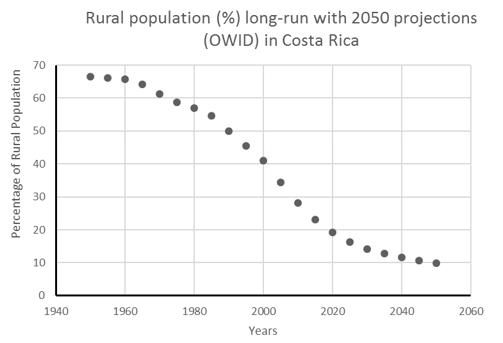

In [10]:
# Checking the first image
Image(df['image_path'][0])

In [11]:
# Checking the first data series to see if it matches the first image
df['data-series'][0]

[{'x': 1949.4200576738224, 'y': 66.6830395839353},
 {'x': 1954.6107016981737, 'y': 66.27853221612253},
 {'x': 1959.9935917975008, 'y': 65.67177116440337},
 {'x': 1964.7997436719, 'y': 64.05374169315228},
 {'x': 1969.2214033963473, 'y': 61.424443802369275},
 {'x': 1974.2198013457225, 'y': 58.79514591158626},
 {'x': 1979.9871835950016, 'y': 56.97486275642879},
 {'x': 1984.601089394425, 'y': 54.75007223345855},
 {'x': 1989.407241268824, 'y': 49.69373013579891},
 {'x': 1994.4056392181992, 'y': 45.44640277376482},
 {'x': 1999.4040371675744, 'y': 40.99682172782434},
 {'x': 2004.7869272669016, 'y': 34.322450158913625},
 {'x': 2009.593079141301, 'y': 28.254839641722064},
 {'x': 2014.3992310157, 'y': 23.19849754406242},
 {'x': 2019.5898750400513, 'y': 18.951170182028324},
 {'x': 2024.3960269144504, 'y': 16.321872291245317},
 {'x': 2029.3944248638256, 'y': 13.89482808436869},
 {'x': 2034.3928228132008, 'y': 12.479052297023994},
 {'x': 2039.1989746876002, 'y': 11.670037561398454},
 {'x': 2044.197

In [12]:
# Save to csv file
df.to_csv('../data/interim/annots_imgs_merged.csv')

# Step 4: Subset the Data
* Since we are working with over 60,000 images, this will be computationally expensive. We will try to work with a small subset of images first before scaling up to the full set of images.

* We will take 500 images, with 100 of each chart type


In [13]:
df = pd.read_csv('../data/interim/annots_imgs_merged.csv')

# Taking just the relevant columns
img_df = df[['chart-type','source','data-series','image_path','file_name']]

# Renaming the columns
img_df.columns = columns=['chart_type','source','data_series','path','name']
img_df.head()

,chart_type,source,data_series,path,name
0,scatter,generated,"[{'x': 1949.4200576738224, 'y': 66.68303958393...",../data/raw/train/images/e91e28111e86.jpg,e91e28111e86
1,vertical_bar,generated,"[{'x': 'Jordan', 'y': 88.35159235668789}, {'x'...",../data/raw/train/images/75c0449f6917.jpg,75c0449f6917
2,scatter,generated,"[{'x': 0.9445463278316278, 'y': 52.13870797394...",../data/raw/train/images/66dd2a250237.jpg,66dd2a250237
3,vertical_bar,generated,"[{'x': 'Cuba', 'y': 75695.38632268383}, {'x': ...",../data/raw/train/images/58595c30beab.jpg,58595c30beab
4,scatter,generated,"[{'x': 0.8933632249058832, 'y': 5.440194292653...",../data/raw/train/images/497a547454d7.jpg,497a547454d7


In [14]:
img_df['chart_type'].value_counts(normalize=True)

line              0.411734
vertical_bar      0.316765
scatter           0.185595
dot               0.084701
horizontal_bar    0.001205
Name: chart_type, dtype: float64

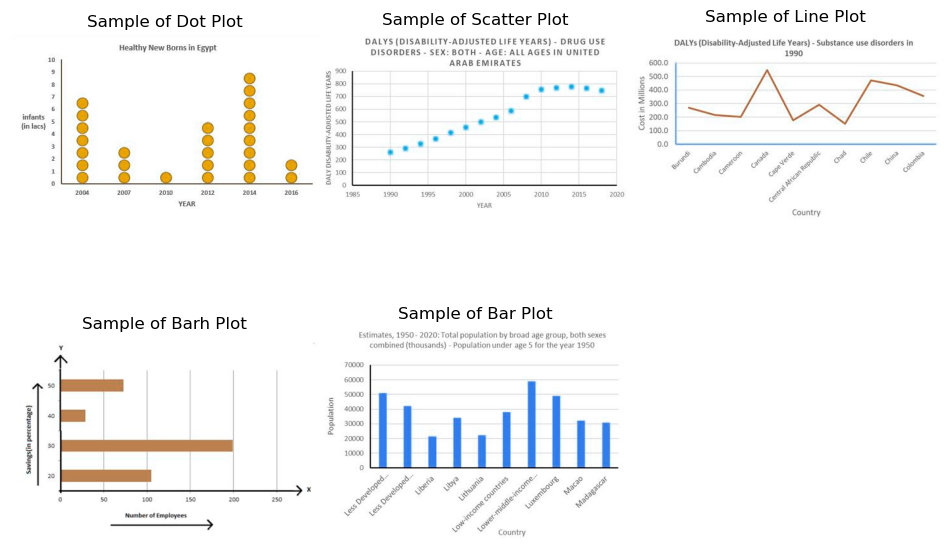

In [16]:
# Plotting a sample of each chart type
fig = plt.figure(figsize=(12, 8))
rows = 2
columns = 3
fig.subplots_adjust(hspace=0.00001, wspace=0.001)

fig.add_subplot(rows, columns, 1)
dot = img_df.query('chart_type == "dot"').sample(random_state=12)['path'].values[0]
dot_im = cv2.imread(dot)
plt.imshow(dot_im)
plt.axis('off')
plt.title("Sample of Dot Plot")


fig.add_subplot(rows, columns, 2)
scatter = img_df.query('chart_type == "scatter"').sample(random_state=12)['path'].values[0]
scatter_im = cv2.imread(scatter)
plt.imshow(scatter_im)
plt.axis('off')
plt.title("Sample of Scatter Plot")

fig.add_subplot(rows, columns, 3)
line = img_df.query('chart_type == "line"').sample(random_state=12)['path'].values[0]
line_im = cv2.imread(line)
plt.imshow(line_im)
plt.axis('off')
plt.title("Sample of Line Plot")


fig.add_subplot(rows, columns, 4)
barh = img_df.query('chart_type == "horizontal_bar"').sample(random_state=12)['path'].values[0]
barh_im = cv2.imread(barh)
plt.imshow(barh_im)
plt.axis('off')
plt.title("Sample of Barh Plot")

fig.add_subplot(rows, columns, 5)
bar = img_df.query('chart_type == "vertical_bar"').sample(random_state=12)['path'].values[0]
bar_im = cv2.imread(bar)
plt.imshow(bar_im)
plt.axis('off')
plt.title("Sample of Bar Plot")

plt.show()



In [17]:
images_per_chart_type = {
    "line": round(20000*0.411734),
    "vertical_bar": round(20000*0.316765),
    "scatter": round(20000*0.185595),
    "dot": round(20000*0.084701),
    "horizontal_bar": round(20000*0.001205)
    
}

subset_data = []

for chart_type, count in images_per_chart_type.items():
    group_df = img_df[img_df['chart_type'] == chart_type]
    sampled_group = group_df.sample(n=count, random_state=42, replace=True)
    subset_data.append(sampled_group)

subset_data = pd.concat(subset_data).reset_index(drop=True)

print(f"Subset data shape: {subset_data.shape}")
print(subset_data['chart_type'].value_counts())


Subset data shape: (20000, 5)
line              8235
vertical_bar      6335
scatter           3712
dot               1694
horizontal_bar      24
Name: chart_type, dtype: int64


# Step 5: Augment the Horizontal Bar Plots to create synthetic Images

In [36]:
# Specify the path to the directory where the augmented images will be saved
augmented_images_dir = '../data/processed/augment_images'

# Create the augmented images directory if it doesn't exist
if not os.path.exists(augmented_images_dir):
    os.makedirs(augmented_images_dir)

# Set the augmentation parameters
scaling_factors = [0.5,0.8, 1.2, 1.5, 1.8, 2.0]  # Scaling factors for resizing
flip_modes = [0,1,-1]  # Flip modes: 0 for horizontal flip, 1 for vertical flip, -1 for both flips
translations = [(20, 0), (-20, 0), (0, 20), (0, -20)]  # Translation amounts in pixels

# Filter subset_data for horizontal_bar charts
horizontal_bar_data = subset_data[subset_data['chart_type'] == 'horizontal_bar']

# Iterate through each horizontal_bar chart
for index, row in horizontal_bar_data.iterrows():
    image_path = row['path']  # Assuming the image paths are stored in a column called 'image_path'

    image = cv2.imread(image_path)

    # Apply scaling
    for factor in scaling_factors:
        scaled_image = cv2.resize(image, None, fx=factor, fy=factor)
        augmented_image_path = os.path.join(augmented_images_dir, f'scaled_{factor}_{os.path.basename(image_path)}')
        cv2.imwrite(augmented_image_path, scaled_image)

    # Apply flipping
    for flip_mode in flip_modes:
        flipped_image = cv2.flip(image, flip_mode)
        flip_mode_name = 'horizontal' if flip_mode == 0 else 'vertical' if flip_mode == 1 else 'both'
        augmented_image_path = os.path.join(augmented_images_dir, f'flipped_{flip_mode_name}_{os.path.basename(image_path)}')
        cv2.imwrite(augmented_image_path, flipped_image)

    # Apply translation
    for translation in translations:
        M = np.float32([[1, 0, translation[0]], [0, 1, translation[1]]])
        translated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
        augmented_image_path = os.path.join(augmented_images_dir, f'translated_{translation[0]}_{translation[1]}_{os.path.basename(image_path)}')
        cv2.imwrite(augmented_image_path, translated_image)

In [37]:
# Path to augmented image files
aug_folder_path = '../data/processed/augment_images/'

# List of json files extracted using glob()
aug_imgs = glob.glob(f"{aug_folder_path}/*.jpg")

# Saving augmented paths as a df
aug_df = pd.DataFrame(aug_imgs, columns=['path'])

# Concat with subset data and fill NaN for chart type column
subset_with_augs = pd.concat([subset_data,aug_df])
subset_with_augs['chart_type'].fillna('horizontal_bar', inplace=True)

In [42]:
# Look at the new value counts
subset_with_augs['chart_type'].value_counts()

line              8235
vertical_bar      6335
scatter           3712
dot               1694
horizontal_bar     271
Name: chart_type, dtype: int64

In [41]:
# Save csv files
subset_data.to_csv('../data/processed/subset_data.csv', index=False)
subset_with_augs.to_csv('../data/processed/subset_with_augs.csv', index=False)